In this project, we wiill  
 Interpret the model results to the extent possible  
 Draw conclusions and write a well-documented report

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


In [4]:
train_features = pd.read_csv('data/training_features.csv')
test_features = pd.read_csv('data/testing_features.csv')
train_labels = pd.read_csv('data/training_labels.csv')
test_labels = pd.read_csv('data/testing_labels.csv')

# Re-create the final model

In [5]:
# Create an imputer object with a median filling strategy
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

# Train on the training features
imputer.fit(train_features)

# Transform both training data and testing data
X_train = imputer.transform(train_features)
X_test = imputer.transform(test_features)

# Sklearn wants the labels as one-dimensional vectors
y_train = np.array(train_labels).reshape((-1,))
y_test = np.array(test_labels).reshape((-1,))

In [6]:
from sklearn.ensemble import RandomForestRegressor
bootstrap_tree_leaf_number = RandomForestRegressor(
    n_estimators=1000,
    min_samples_split=2,
    min_samples_leaf=60,
    min_impurity_decrease=0.0,
    max_features=None,
    max_depth=5,
    ccp_alpha=0.04,
    bootstrap=True,
    random_state=42
)


In [7]:
bootstrap_tree_leaf_number.fit(X_train, y_train)

RandomForestRegressor(ccp_alpha=0.04, max_depth=5, max_features=None,
                      min_samples_leaf=60, n_estimators=1000, random_state=42)

In [8]:
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [9]:
#  Make predictions on the test set
model_pred = bootstrap_tree_leaf_number.predict(X_test)

print('Final Model Performance on the test set: MAE = %0.4f' % mae(y_test, model_pred))

Final Model Performance on the test set: MAE = 10.9598


# Intrepret the model

## Feature Importance

In [10]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(train_features.columns), 
                                'importance': bootstrap_tree_leaf_number.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)
feature_results.head(10)

,feature,importance
0,Site EUI (kBtu/ft²),0.732855
1,Weather Normalized Site Electricity Intensity ...,0.172325
2,Largest Property Use Type_Multifamily Housing,0.084471
3,DOF Gross Floor Area,0.003330
4,Census Tract,0.001663
5,Property Id,0.001190
6,Year Built,0.001086
7,Longitude,0.001011
8,Order,0.000778
9,log_Water Intensity (All Water Sources) (gal/ft²),0.000357


Text(0.5, 1.0, 'Feature Importances from Random Forest')

<Figure size 2000x1000 with 0 Axes>

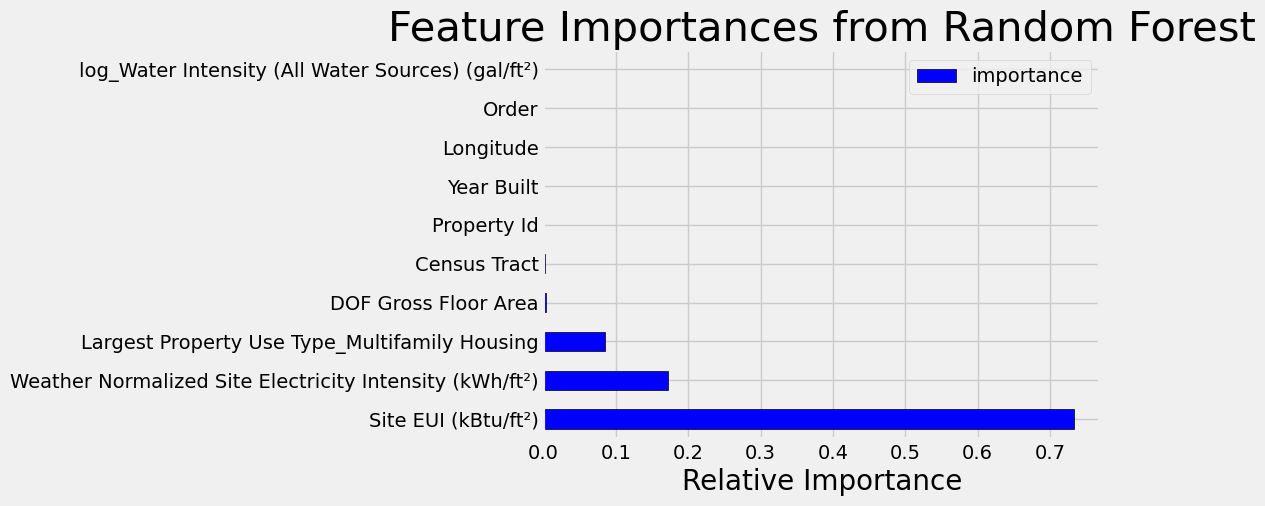

In [11]:
plt.figure(figsize=(20, 10))

plt.style.use('fivethirtyeight')

# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue')
plt.xlabel('Relative Importance', size = 20)
plt.ylabel('')
plt.title('Feature Importances from Random Forest', size = 30)

## Try to use Linear Regression Use 10 most important features to compare with the Random Forest.

In [12]:
# Extract the names of the most important features
most_important_features = feature_results['feature'][:10]

# Find the index that corresponds to each feature name
indices = [list(train_features.columns).index(x) for x in most_important_features]

# Keep only the most important features
X_reduced = X_train[:, indices]
X_test_reduced = X_test[:, indices]

print('Most important training features shape: ', X_reduced.shape)
print('Most important testing  features shape: ', X_test_reduced.shape)

Most important training features shape:  (6349, 10)
Most important testing  features shape:  (2722, 10)


In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

# Fit on full set of features
lr.fit(X_train, y_train)
lr_full_pred = lr.predict(X_test)

# Fit on reduced set of features
lr.fit(X_reduced, y_train)
lr_reduced_pred = lr.predict(X_test_reduced)

# Display results
print('Linear Regression Full Results: MAE =    %0.4f.' % mae(y_test, lr_full_pred))
print('Linear Regression Reduced Results: MAE = %0.4f.' % mae(y_test, lr_reduced_pred))

Linear Regression Full Results: MAE =    12.6928.
Linear Regression Reduced Results: MAE = 14.1151.


We found that not use the unimportant features does not improve the performance. 

### Try again with the randomForest model

In [14]:
model_reduced = RandomForestRegressor(
    n_estimators=1000,
    min_samples_split=2,
    min_samples_leaf=60,
    min_impurity_decrease=0.0,
    max_features=None,
    max_depth=5,
    ccp_alpha=0.04,
    bootstrap=True,
    random_state=42
)

In [15]:
# Fit and test on the reduced set of features
model_reduced.fit(X_reduced, y_train)
model_reduced_pred = model_reduced.predict(X_test_reduced)

print('Random Forest Reduced Results: MAE = %0.4f' % mae(y_test, model_reduced_pred))

Random Forest Reduced Results: MAE = 10.9629


The original one use all data is 10.9598, thus, from our expirement, it dones't help using only important features. 

# Locally Interpretable Model-agnostic Explanations

LIME is a relatively new effort aimed at showing how a machine learning model thinks by approximating the region around a prediction with a linear model.

In [16]:
# Find the residuals
residuals = abs(model_reduced_pred - y_test)
    
# Exact the worst and best prediction
wrong = X_test_reduced[np.argmax(residuals), :]
right = X_test_reduced[np.argmin(residuals), :]

In [17]:
wrong

array([ 2.65000000e+01,  7.70000000e+00,  0.00000000e+00,  1.22608000e+05,
        2.17000000e+02,  2.89390200e+06,  1.99700000e+03, -7.39621350e+01,
        1.24440000e+04,  1.04027671e+00])

In [18]:
import lime 
import lime.lime_tabular



explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_reduced, 
                                                   mode = 'regression',
                                                   training_labels = y_train,
                                                   feature_names = list(most_important_features))

/var/folders/z_/_svpfmcs5fl0mkczt0127k680000gn/T/ipykernel_37347/2477490040.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))


Prediction: 81.6616
Actual Value: 4.0000


Text(0.5, 0, 'Effect on Prediction')

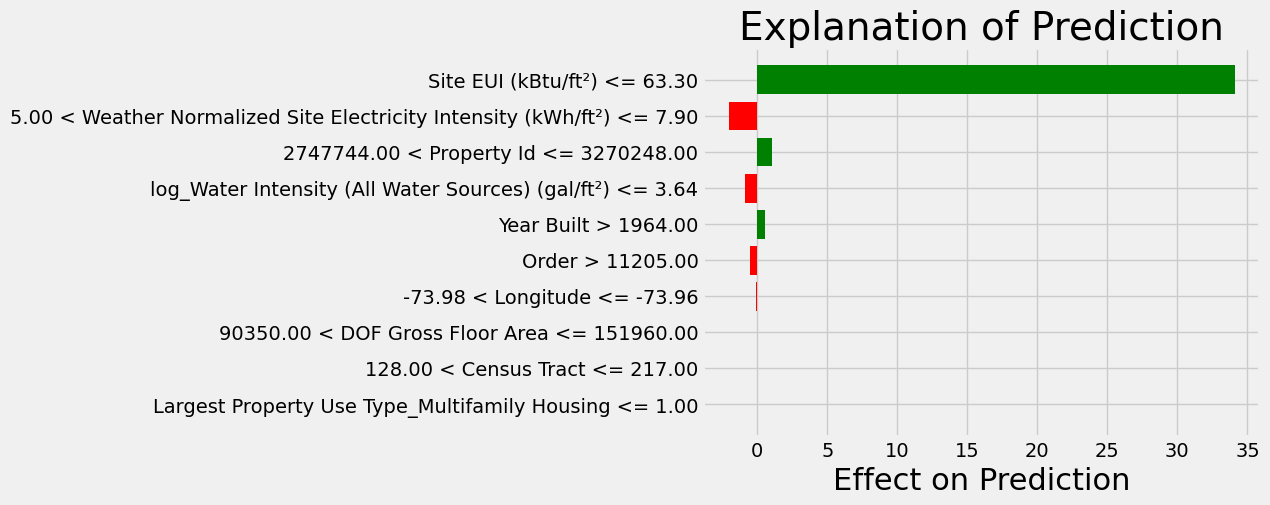

In [34]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(wrong.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmax(residuals)])

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = model_reduced.predict)

# Plot the prediction explaination
wrong_exp.as_pyplot_figure()
plt.title('Explanation of Prediction', size = 28)
plt.xlabel('Effect on Prediction', size = 22)

In [20]:
wrong_exp.show_in_notebook(show_predicted_value=False)

/var/folders/z_/_svpfmcs5fl0mkczt0127k680000gn/T/ipykernel_37347/2277720504.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))


Prediction: 88.0015
Actual Value: 88.0000


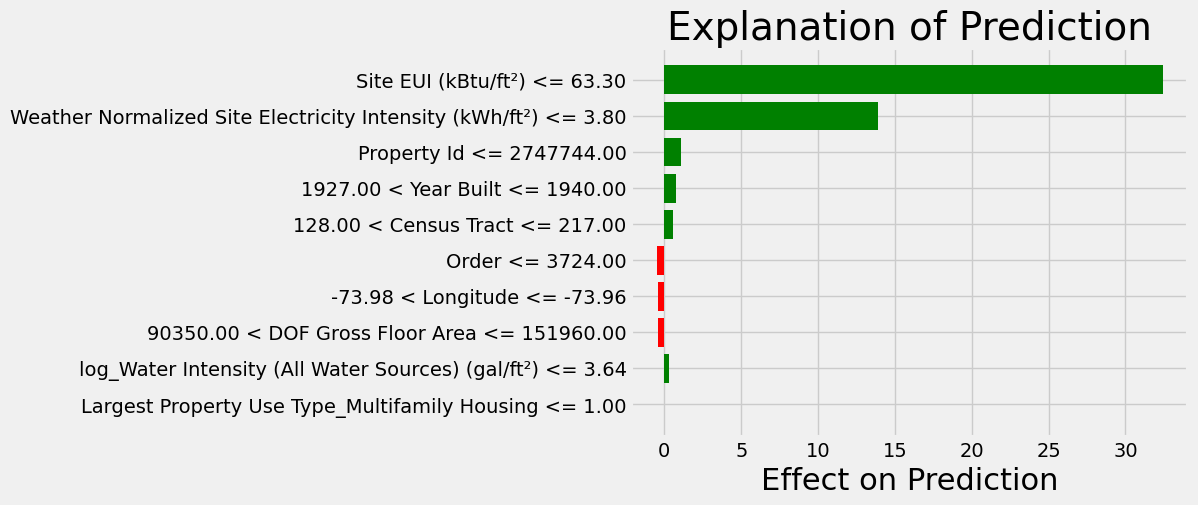

In [21]:
# Display the predicted and true value for the wrong instance
print('Prediction: %0.4f' % model_reduced.predict(right.reshape(1, -1)))
print('Actual Value: %0.4f' % y_test[np.argmin(residuals)])

# Explanation for wrong prediction
right_exp = explainer.explain_instance(right, model_reduced.predict, num_features=10)
right_exp.as_pyplot_figure();
plt.title('Explanation of Prediction', size = 28);
plt.xlabel('Effect on Prediction', size = 22);

In [22]:
right_exp.show_in_notebook(show_predicted_value=False)

## Examining a Single Decision Tree


In [24]:
model_reduced.estimators_

[DecisionTreeRegressor(ccp_alpha=0.04, max_depth=5, min_samples_leaf=60,
                       random_state=1608637542),
 DecisionTreeRegressor(ccp_alpha=0.04, max_depth=5, min_samples_leaf=60,
                       random_state=1273642419),
 DecisionTreeRegressor(ccp_alpha=0.04, max_depth=5, min_samples_leaf=60,
                       random_state=1935803228),
 DecisionTreeRegressor(ccp_alpha=0.04, max_depth=5, min_samples_leaf=60,
                       random_state=787846414),
 DecisionTreeRegressor(ccp_alpha=0.04, max_depth=5, min_samples_leaf=60,
                       random_state=996406378),
 DecisionTreeRegressor(ccp_alpha=0.04, max_depth=5, min_samples_leaf=60,
                       random_state=1201263687),
 DecisionTreeRegressor(ccp_alpha=0.04, max_depth=5, min_samples_leaf=60,
                       random_state=423734972),
 DecisionTreeRegressor(ccp_alpha=0.04, max_depth=5, min_samples_leaf=60,
                       random_state=415968276),
 DecisionTreeRegressor(ccp_a

In [27]:
from sklearn import tree

# Extract a single tree
single_tree = model_reduced.estimators_[0]


import os

if not os.path.exists('images'):
    os.makedirs('images')

tree.export_graphviz(single_tree, out_file = 'images/tree.dot',
                     rounded = True, 
                     feature_names = most_important_features,
                     filled = True)

single_tree

DecisionTreeRegressor(ccp_alpha=0.04, max_depth=5, min_samples_leaf=60,
                      random_state=1608637542)

In [29]:
!dot -Tpng images/tree.dot -o images/tree.png


In [31]:
tree.export_graphviz(single_tree, out_file = 'images/tree_small.dot',
                     rounded = True, feature_names = most_important_features,
                     filled = True, max_depth = 5)

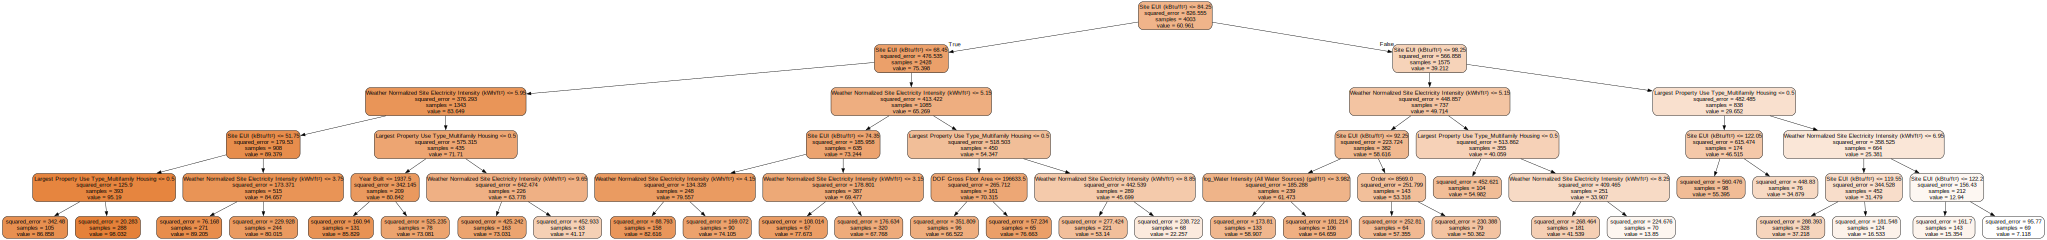

In [33]:
from graphviz import Source

with open('images/tree.dot') as f:
    dot_graph = f.read()

Source(dot_graph)